In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn
import time

def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

C:\Users\hieri\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

In [3]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [4]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

In [5]:
concat_preds([Y1, Y2]).shape

(2, 25300)

In [6]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

In [7]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

In [8]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

In [10]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1
print(num_anchors)

4


In [12]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # 即赋值语句self.blk_i = get_blk(i)
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors,
                                                      num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, 'blk_%d' % i), sizes[i], ratios[i],
                getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
        # reshape函数中的0表示保持批量大小不变
        return (nd.concat(*anchors, dim=1),
                concat_preds(cls_preds).reshape(
                 (0, -1, self.num_classes + 1)), concat_preds(bbox_preds))

In [71]:
import numpy as np
net = TinySSD(num_classes=11)
net.initialize()
X = nd.zeros(( 32 , 3, 1920, 1200))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)
net

output anchors: (1, 191044, 4)
output class preds: (32, 191044, 12)
output bbox preds: (32, 764176)


TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2D(3 -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
      (2): Activation(relu)
      (3): Conv2D(16 -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2D(16 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
      (2): Activation(relu)
      (3): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels

In [15]:
import os

batch_size = 32

def load_data_object(batch_size, edge_size=256):
    """Download the pikachu dataest and then load into memory."""
    data_dir = '.'
    print(edge_size)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'my_data.rec'),
        path_imgidx=os.path.join(data_dir, 'my_data.idx'),
        batch_size=batch_size,
        data_shape=(3, 512, 256),
        shuffle=True,
        rand_crop=1,
        min_object_covered=0.95)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'my_data.rec'),
        batch_size=batch_size,
        data_shape=(3, 512, 256),
        shuffle=False)
    return train_iter, val_iter

train_iter, _ = load_data_object(batch_size)




256


In [17]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=11)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})



In [18]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

In [19]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

In [28]:
for epoch in range(35):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    start = time.time()
    i = 0
    for batch in train_iter:
        if(i == 40):
            break
        
        print("Batch: "+str(i))
        i+=1;
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size

    print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
                epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
epoch  1, class err 5.95e-03, bbox mae 7.00e-03, time 705.5 sec
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
epoch  2, class err 4.28e-03, bbox mae 6.57e-03, time 700.9 sec
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Ba

Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
epoch 19, class err 3.78e-03, bbox mae 5.19e-03, time 706.8 sec
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
epoch 20, class err 4.11e-03, bbox mae 5.44e-03, time 706.1 sec
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12

In [72]:
img = image.imread('object-dataset/1478731941307150648.jpg')
feature = image.imresize(img, 512, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

In [73]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]


output = predict(X)
print(output)


[[1.         0.3581888  0.76325625 0.21001518 0.9564797  0.6418357 ]
 [5.         0.35034794 0.7408265  0.08605796 0.9415449  0.90952545]
 [1.         0.34473702 0.5069743  0.         0.698567   0.2593519 ]
 ...
 [1.         0.08984533 0.08117402 0.81588924 0.15096325 1.        ]
 [7.         0.08974864 0.04981082 0.81561446 0.11990061 1.        ]
 [1.         0.08870268 0.         0.70675814 0.08275838 1.        ]]
<NDArray 2100x6 @cpu(0)>


KeyError: 0

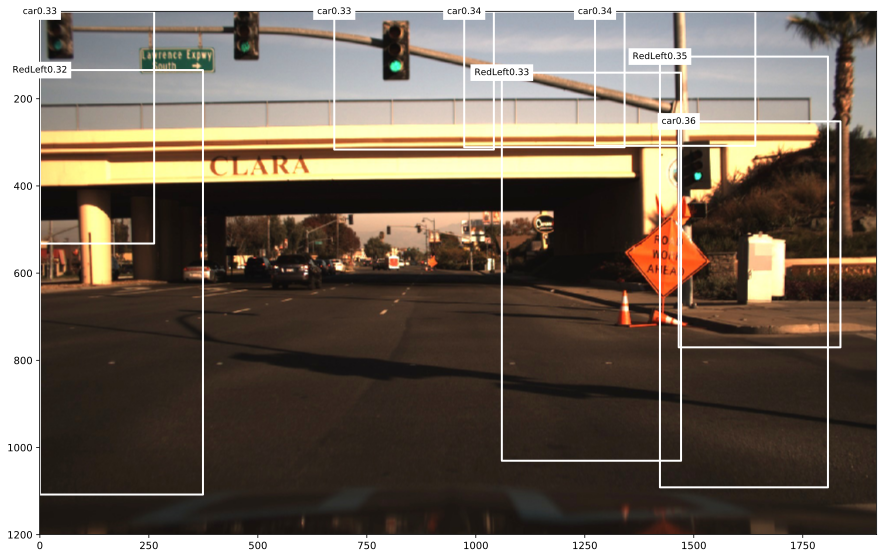

In [76]:
d2l.set_figsize((15, 15))

pool = {1: 'car',
 2: 'pedestrian',
 3: 'truck',
 4: 'Red',
 5: 'RedLeft',
 6: 'biker',
 7: 'trafficLight',
 8: 'Green',
 9: 'GreenLeft',
 10: 'YellowLeft',
 11: 'Yellow'}


def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        clss = pool[int(row.asnumpy()[0])] 
        d2l.show_bboxes(fig.axes, bbox, clss+'%.2f' % score, 'w')

display(img, output, threshold=0.1)

In [27]:
d2l.load_data_pikachu??

In [44]:
d2l.show_bboxes??

In [51]:
pool = {'"car"': 1, '"pedestrian"': 2, '"truck"': 3, '"Red"': 4, '"RedLeft"': 5, '"biker"': 6,
        '"trafficLight"': 7, '"Green"': 8, '"GreenLeft"': 9, '"YellowLeft"': 10, '"Yellow"': 11}
rpool = {}
for k in pool:
    newk = k.replace("\"", "")
    rpool[pool[k]] = newk
rpool

{1: 'car',
 2: 'pedestrian',
 3: 'truck',
 4: 'Red',
 5: 'RedLeft',
 6: 'biker',
 7: 'trafficLight',
 8: 'Green',
 9: 'GreenLeft',
 10: 'YellowLeft',
 11: 'Yellow'}